<a href="https://colab.research.google.com/github/Ryan-RE-Wang/NTHU_ML-HW3/blob/main/ML_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [ ]:
!unzip /content/drive/MyDrive/ML_HW3/IML_CXR_TRAIN.zip

In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import tensorflow as tf
import cv2 as cv
import gc
from enum import Enum
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_precision_recall_curve, average_precision_score, roc_curve, auc, classification_report
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.ensemble import StackingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier
import tensorflow_addons as tfa
from sklearn.preprocessing import MinMaxScaler
from google.colab.patches import cv2_imshow
from skimage.util import random_noise
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from joblib import dump, load
from sklearn import tree
import warnings
warnings.filterwarnings("ignore")


df_label = pd.read_csv('/content/drive/MyDrive/ML_HW3/cxr_label_train.csv')
df_ehr = pd.read_csv('/content/drive/MyDrive/ML_HW3/hm_hospitales_covid_structured_30d_train.csv')
df_ehr_label = pd.read_csv('/content/drive/MyDrive/ML_HW3/split_train_export_30d.csv')

# some functions

In [ ]:
def rotation(img, angle):
    w = img.shape[1]
    h = img.shape[0]

    M = cv.getRotationMatrix2D((w/2, w/2), angle, 1)
    rot_img = cv.warpAffine(img, M, (w,h))

    return rot_img

def gaussian_noise(img):
    w = img.shape[1]
    h = img.shape[0]
    gaussian = np.random.random((w, h, 1)).astype(np.float32)
    gaussian_img = cv.addWeighted(img, 0.75, 0.25 * gaussian, 0.25, 0)

    return gaussian_img

def flip_ver(img):
    return np.flipud(img)

def flip_hor(img):
    return np.fliplr(img)

def center_crop(img):
    w = img.shape[1]/2
    h = img.shape[0]/2

    x = w/2
    y = h/2

    img = img[int(y):int(y+h), int(x):int(x+w)]
    img = cv.resize(img, (256, 256))
    
    return img

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.show()


In [ ]:
def plot_roc(preds, y_test, title):

    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    # plot the roc curve for the model
    plt.plot(fpr, tpr, linestyle='solid', label='AUC={:.3f} n={}'.format(roc_auc, len(y_test)))
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)

    plt.plot([0,1], [0,1], color='orange', linestyle='--', label='Baseine')
    plt.legend()

    print(classification_report(y_test, preds))

    
    plt.show()

In [ ]:
def plot_calibration(y_test, preds):
    plt.figure(figsize=(12, 8))
    # only these two lines are calibration curves
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, preds, n_bins=10)

    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label = 'DenseNet121')

    # reference line, legends, and axis labels
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    # transform = ax.transAxes
    plt.title('Calibration plot')
    plt.xlabel('Predicted probability')
    plt.ylabel('True probability in each bin')

    plt.legend()
    plt.show()

In [ ]:
def preprocess(df):
  df['sex'] = df['sex'].replace({'MALE':0, 'FEMALE':1})

  col = df.columns[9:21]

  for i in col:
    df[i] = df[i].fillna(0)

  df[sorted(df['ed_diagnosis'].unique())] = 0

  for j in df.index:
    symptom = df['ed_diagnosis'][j]
    df[symptom][j] = 1

  df = df.drop(['ed_diagnosis'], axis=1)

  numerical_col = []
  for i in df.columns:
    if (df[i].isnull().sum() != 0):
      numerical_col.append(i)

  scaler = MinMaxScaler()
  for i in numerical_col:
    median = df[i].median(skipna=True)
    df[i] = df[i].fillna(median)
    
  df = df.drop(['admission_datetime'], axis=1)
  df = df.drop(symptom, axis=1)

  return df

df_ehr_ = preprocess(df_ehr)

# get data

In [ ]:
base_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/cxr_model_test_with_1_11_19')
last_layer = base_model.get_layer('max_pool').output

new_model = tf.keras.models.Model(inputs=base_model.inputs, outputs=last_layer) 
new_model.trainable = False

In [ ]:
def get_data():
    X = []
    X_ehr = []
    y = []
 
    path = 'IML_CXR'
    dirs = os.listdir(path)
    col = df_ehr_.columns[1:]
 
    for i in dirs:
        file_path = '/content/IML_CXR/' + i
 
        img = cv.imread(file_path, cv.IMREAD_GRAYSCALE)
        img = cv.resize(img, (256, 256))
        img = np.float32(img)
 
        id = i[:len(i)-4]
 
        id = np.int(id)
        outcome = df_label.loc[df_label['PATIENT ID'] == id, 'hospital_outcome'].values
 
        data = df_ehr_.loc[df_ehr_['PATIENT ID'] == id, col].values
 
        X.append(img)
        y.append(outcome[0])
        X_ehr.append(data[0])
 
    X_train, X_test, X_ehr_train, X_ehr_test, y_train, y_test = train_test_split(X, X_ehr, y, test_size=0.2, random_state=1)

    limit = len(X_train)
 
    for index in range(limit):
        if (y_train[index] == 1):
            for i in range(1):
                X_train.append(rotation(X_train[index], np.random.randint(-10, 10)))
                y_train.append(y_train[index])
                X_ehr_train.append(X_ehr_train[index])
 
    X_train = new_model.predict(np.array(X_train))
    y_train = np.array(y_train)
 
    X_ehr_train = np.array(X_ehr_train)
    X_ehr_test = np.array(X_ehr_test)
 
    X_test = new_model.predict(np.array(X_test))
    y_test = np.array(y_test)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)

    scaler.fit(X_test)
    X_test = scaler.transform(X_test)

    scaler.fit(X_ehr_train)
    X_ehr_train = scaler.transform(X_ehr_train)

    scaler.fit(X_ehr_test)
    X_ehr_test = scaler.transform(X_ehr_test)
 
    return X_train, X_test, X_ehr_train, X_ehr_test, y_train, y_test

    # return X_train, X_ehr_train, y_train
 
X_train, X_test, X_ehr_train, X_ehr_test, y_train, y_test = get_data()
# X_train, X_ehr_train, y_train = get_data()

X_combine_train = np.empty((X_train.shape[0], X_train.shape[1]+X_ehr_train.shape[1]))
for i in range(X_train.shape[0]):
    X_combine_train[i] = np.append(X_train[i], X_ehr_train[i], axis=0)
 
X_combine_test = np.empty((X_test.shape[0], X_test.shape[1]+X_ehr_test.shape[1]))
for i in range(X_test.shape[0]):
    X_combine_test[i] = np.append(X_test[i], X_ehr_test[i], axis=0)

# build model

In [ ]:
def build_cxr(input_shape, output_units):
    input_layer = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(units=512, activation='relu')(input_layer)
    
    x = tf.keras.layers.Dense(units=128, activation='relu')(x)

    x = tf.keras.layers.Dense(units=32, activation='relu')(x)

    x = tf.keras.layers.Dense(units=4, activation='relu', name='last_cxr')(x)
    
    out = tf.keras.layers.Dense(units=output_units, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs=[input_layer], outputs=[out])

    return model

In [ ]:
def build_ehr(input_shape, output_units):
    input_layer = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(units=64, activation='relu')(input_layer)
    
    x = tf.keras.layers.Dense(units=32, activation='relu')(x)

    x = tf.keras.layers.Dense(units=16, activation='relu')(x)

    x = tf.keras.layers.Dense(units=4, activation='relu', name='last_ehr')(x)
    
    out = tf.keras.layers.Dense(units=output_units, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs=[input_layer], outputs=[out])

    return model

In [ ]:
def build_combine(input_shape, output_units):
    input_layer = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(units=512, activation='relu')(input_layer)
    
    x = tf.keras.layers.Dense(units=128, activation='relu')(x)

    x = tf.keras.layers.Dense(units=64, activation='relu')(x)

    x = tf.keras.layers.Dense(units=16, activation='relu')(x)
    
    out = tf.keras.layers.Dense(units=output_units, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs=[input_layer], outputs=[out])

    return model

In [ ]:
def get_model(X_train, X_ehr_train):

    cxr = build_cxr(input_shape=(X_train.shape[1], ), output_units=8)
    last_layer_cxr = cxr.get_layer('last_cxr').output
    
    ehr = build_ehr(input_shape=(X_ehr_train.shape[1], ), output_units=8)
    last_layer_ehr = ehr.get_layer('last_ehr').output

    combined = tf.keras.layers.concatenate([last_layer_cxr, last_layer_ehr])
    
    x = tf.keras.layers.Dense(units=8, activation='relu')(combined)

    pred = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=[cxr.input, ehr.input], outputs=pred)

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)) #tf.keras.losses.BinaryCrossentropy(from_logits=True))
    
    model.summary()

    return model

# Training

In [ ]:
def set_threshold(y_pred, threshold):
    preds = []
    for i in range(len(y_pred)):
        if (y_pred[i] >= threshold):
            preds.append(1)
        else:
            preds.append(0)
    return preds

## CXR only

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='f1_score', patience=3, mode='max')

model = build_cxr(input_shape=(X_train.shape[1], ), output_units=1)

model.summary()
 
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
              )
 
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=25, shuffle=True)
model.save('/content/drive/MyDrive/ML_HW3/models/CXR/mlp_CXR')

y_pred = model.predict(X_test)
    
preds_mlp_cxr = set_threshold(y_pred, 0.45)
print(classification_report(y_test, np.array(preds_mlp_cxr)))
 
# plot_loss(history)
 
# plot_roc(clf=model, X_test=X_combine_test, X_ehr_test=None, y_test=y_test, title='roc for mlp')
 
# plot_calibration(y_test, y_pred)

Model: "model_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_234 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_235 (Dense)            (None, 128)               65664     
_________________________________________________________________
dense_236 (Dense)            (None, 32)                4128      
_________________________________________________________________
last_cxr (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_237 (Dense)            (None, 1)                 5         
Total params: 594,729
Trainable params: 594,729
Non-trainable params: 0
____________________________________________________

## CXR + EHR

In [ ]:
model = get_model(X_train, X_ehr_train)
 
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))
 
history = model.fit(x=[X_train,X_ehr_train], y=y_train, batch_size=32, epochs=25, shuffle=True)
model.save('/content/drive/MyDrive/ML_HW3/models/Combine/combine_mlp_Combine')
 
# plot_loss(history)
 
# y_pred = plot_roc(clf=model, X_test=X_test, X_ehr_test=X_ehr_test, y_test=y_test, title='roc for combine mlp')
 
# plot_calibration(y_test, y_pred)

y_pred = model.predict([X_test, X_ehr_test])
    
preds_com = set_threshold(y_pred, 0.45)
print(classification_report(y_test, np.array(preds_com)))

Model: "model_64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_45 (InputLayer)           [(None, 49)]         0                                            
__________________________________________________________________________________________________
dense_210 (Dense)               (None, 512)          524800      input_44[0][0]                   
__________________________________________________________________________________________________
dense_214 (Dense)               (None, 64)           3200        input_45[0][0]                   
___________________________________________________________________________________________

In [ ]:
model = build_combine(input_shape=(X_combine_train.shape[1], ), output_units=1)

model.summary()
 
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))
 
history = model.fit(x=X_combine_train, y=y_train, batch_size=32, epochs=20, shuffle=True)
model.save('/content/drive/MyDrive/ML_HW3/models/Combine/mlp_Combine')

y_pred = model.predict(X_combine_test)
    
preds_mlp_com = set_threshold(y_pred, 0.45)
print(classification_report(y_test, np.array(preds_mlp_com)))
 
# plot_loss(history)
 
# plot_roc(clf=model, X_test=X_combine_test, X_ehr_test=None, y_test=y_test, title='roc for mlp')
 
# plot_calibration(y_test, y_pred)

Model: "model_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        [(None, 1073)]            0         
_________________________________________________________________
dense_225 (Dense)            (None, 512)               549888    
_________________________________________________________________
dense_226 (Dense)            (None, 128)               65664     
_________________________________________________________________
dense_227 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_228 (Dense)            (None, 16)                1040      
_________________________________________________________________
dense_229 (Dense)            (None, 1)                 17        
Total params: 624,865
Trainable params: 624,865
Non-trainable params: 0
____________________________________________________

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

clf = XGBClassifier().fit(X_combine_train, y_train)
dump(clf, '/content/drive/MyDrive/ML_HW3/models/Combine/XGBoost_Combine.joblib')
y_pred = clf.predict_proba(X_combine_test)
preds_xgb = []
for i in range(len(y_test)):
    if (y_pred[i][1] >= 0.45):
        preds_xgb.append(1)
    else:
        preds_xgb.append(0)
print('XGBClassifier\n', classification_report(y_test, np.array(preds_xgb)))

clf = LogisticRegression(random_state=0).fit(X_combine_train, y_train)
dump(clf, '/content/drive/MyDrive/ML_HW3/models/Combine/LR_Combine.joblib')
y_pred = clf.predict_proba(X_combine_test)
preds_lr = []
for i in range(len(y_test)):
    if (y_pred[i][1] >= 0.48):
        preds_lr.append(1)
    else:
        preds_lr.append(0)
print('LogisticRegression\n', classification_report(y_test, np.array(preds_lr)))

clf = AdaBoostClassifier(random_state=42).fit(X_combine_train, y_train)
dump(clf, '/content/drive/MyDrive/ML_HW3/models/Combine/Ada_Combine.joblib')
y_pred = clf.predict_proba(X_combine_test)
preds_ada = []
for i in range(len(y_test)):
    if (y_pred[i][1] >= 0.49):
        preds_ada.append(1)
    else:
        preds_ada.append(0)
print('AdaBoostClassifier\n', classification_report(y_test, np.array(preds_ada)))

clf = DecisionTreeClassifier(random_state=0, min_samples_leaf=10).fit(X_combine_train, y_train)
dump(clf, '/content/drive/MyDrive/ML_HW3/models/Combine/DT_Combine.joblib')
y_pred = clf.predict_proba(X_combine_test)
preds_dt = []
for i in range(len(y_pred)):
    if (y_pred[i][1] >= 0.45):
        preds_dt.append(1)
    else:
        preds_dt.append(0)
print('DecisionTreeClassifier\n', classification_report(y_test, np.array(preds_dt)))

clf = RandomForestClassifier(n_estimators=800, max_depth=15).fit(X_combine_train, y_train)
dump(clf, '/content/drive/MyDrive/ML_HW3/models/Combine/RF_Combine.joblib')
y_pred = clf.predict_proba(X_combine_test)
preds_rf = []
for i in range(len(y_pred)):
    if (y_pred[i][1] >= 0.45):
        preds_rf.append(1)
    else:
        preds_rf.append(0)
print('RandomForestClassifier\n', classification_report(y_test, np.array(preds_rf)))

clf = KNeighborsClassifier(n_neighbors=5).fit(X_combine_train, y_train)
dump(clf, '/content/drive/MyDrive/ML_HW3/models/Combine/KNN_Combine.joblib')
y_pred = clf.predict_proba(X_combine_test)
preds_knn = []
for i in range(len(y_pred)):
    if (y_pred[i][1] >= 0.4):
        preds_knn.append(1)
    else:
        preds_knn.append(0)
print('KNeighborsClassifier\n', classification_report(y_test, np.array(preds_knn)))

clf = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0, max_depth=5, random_state=0).fit(X_combine_train, y_train)
dump(clf, '/content/drive/MyDrive/ML_HW3/models/Combine/GB_Combine.joblib')
y_pred = clf.predict_proba(X_combine_test)
preds_gb = []
for i in range(len(y_pred)):
    if (y_pred[i][1] >= 0.45):
        preds_gb.append(1)
    else:
        preds_gb.append(0)
print('GradientBoostingClassifier\n', classification_report(y_test, np.array(preds_gb)))

# plot_roc(clf=clf, X_test=None, X_ehr_test=X_combine_test, y_test=y_test, title='roc for xgboost')
# plot_calibration(y_test, y_pred)

XGBClassifier
               precision    recall  f1-score   support

           0       0.94      0.87      0.90       249
           1       0.34      0.57      0.42        30

    accuracy                           0.84       279
   macro avg       0.64      0.72      0.66       279
weighted avg       0.88      0.84      0.85       279

LogisticRegression
               precision    recall  f1-score   support

           0       0.95      0.82      0.88       249
           1       0.31      0.67      0.43        30

    accuracy                           0.81       279
   macro avg       0.63      0.74      0.65       279
weighted avg       0.88      0.81      0.83       279

AdaBoostClassifier
               precision    recall  f1-score   support

           0       0.98      0.61      0.76       249
           1       0.22      0.90      0.35        30

    accuracy                           0.65       279
   macro avg       0.60      0.76      0.55       279
weighted avg       

In [ ]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier

estimators = [
        ('rf', RandomForestClassifier(n_estimators=800, max_depth=15)),
        ('xgb', XGBClassifier()),
        ('dt', DecisionTreeClassifier(random_state=0, min_samples_leaf=10)),
        ('ada', AdaBoostClassifier(random_state=42)),
        ('knn', KNeighborsClassifier(n_neighbors=15)),
        ('gb', GradientBoostingClassifier(n_estimators=500, learning_rate=1.0, max_depth=5, random_state=0))]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()).fit(X_combine_train, y_train)
dump(clf, '/content/drive/MyDrive/ML_HW3/models/Combine/Stacking_Combine.joblib')
y_pred = clf.predict_proba(X_combine_test)
preds_stacking = []
for i in range(len(y_pred)):
    if (y_pred[i][1] >= 0.49):
        preds_stacking.append(1)
    else:
        preds_stacking.append(0)
print('StackingClassifier\n', classification_report(y_test, np.array(preds_stacking)))

estimators = [
        ('rf', RandomForestClassifier(n_estimators=800, max_depth=15)),
        ('xgb', XGBClassifier()),
        ('dt', DecisionTreeClassifier(random_state=0, min_samples_leaf=10)),
        ('ada', AdaBoostClassifier(random_state=42)),
        ('knn', KNeighborsClassifier(n_neighbors=15)),
        ('gb', GradientBoostingClassifier(n_estimators=500, learning_rate=1.0, max_depth=5, random_state=0)),
        ('lr', LogisticRegression(random_state=0))]

clf = VotingClassifier(estimators=estimators, voting='soft').fit(X_combine_train, y_train)
dump(clf, '/content/drive/MyDrive/ML_HW3/models/Combine/voting_soft_Combine.joblib')
preds_voting_soft = clf.predict(X_combine_test)
print('VotingClassifier soft\n', classification_report(y_test, np.array(preds_voting_soft)))

clf = VotingClassifier(estimators=estimators, voting='hard').fit(X_combine_train, y_train)
dump(clf, '/content/drive/MyDrive/ML_HW3/models/Combine/voting_hard_Combine.joblib')
preds_voting_hard = clf.predict(X_combine_test)
print('VotingClassifier hard\n', classification_report(y_test, np.array(preds_voting_hard)))

StackingClassifier
               precision    recall  f1-score   support

           0       0.94      0.85      0.89       249
           1       0.30      0.53      0.39        30

    accuracy                           0.82       279
   macro avg       0.62      0.69      0.64       279
weighted avg       0.87      0.82      0.84       279

VotingClassifier soft
               precision    recall  f1-score   support

           0       0.93      0.86      0.89       249
           1       0.28      0.43      0.34        30

    accuracy                           0.82       279
   macro avg       0.60      0.65      0.62       279
weighted avg       0.86      0.82      0.83       279

VotingClassifier hard
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       249
           1       0.38      0.50      0.43        30

    accuracy                           0.86       279
   macro avg       0.66      0.70      0.67       279
weighted

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       249
           1       0.35      0.47      0.40        30

    accuracy                           0.85       279
   macro avg       0.64      0.68      0.66       279
weighted avg       0.87      0.85      0.86       279



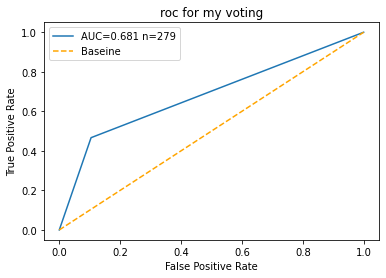

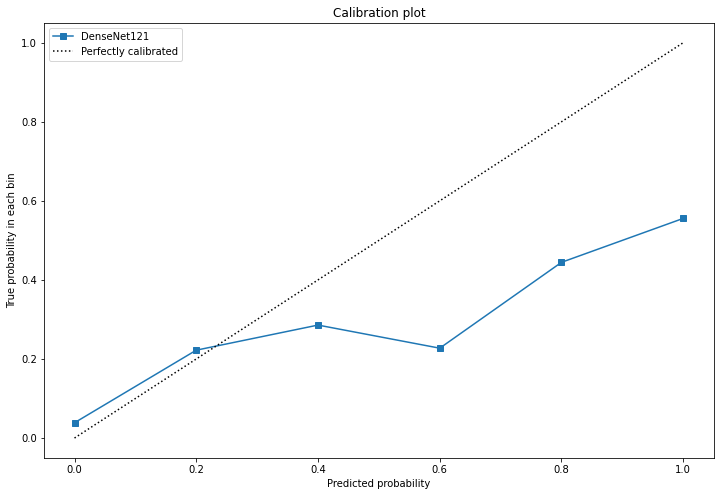

In [ ]:
preds = []
preds_proba = []
for i in range(len(y_test)):
    preds_proba.append((preds_com[i] +preds_mlp_com[i] + preds_stacking[i] + preds_voting_soft[i] + preds_voting_hard[i])/5)
    preds.append(np.round(preds_proba[i]))

plot_roc(preds=preds, y_test=y_test, title='roc for my voting')
plot_calibration(y_test, preds_proba)